# Copula by Ratio Estimation

For a copula denity $c(F_1(x_1),F_2(x_2))=\frac{h(x_1,x_2)}{f_1(x_1)\cdot f_2(x_2)}$, we can reinterpret this as a ratio $\frac{p(x_1,x_2)}{q(x_1,x_2)}=r(x_1,x_2) \in \mathbb{R}^{+}$.

With this insight, let us use density ratio estimation methods to recover the copula density $c$. We will train a classifier given samples from $p$ and $q$, depending on a parameterised function $r_\theta:\mathcal{X}\rightarrow\mathbb{R}^{+}$ to optimise the logistic loss:
$$
\mathcal{L}(\boldsymbol{\theta})=-\mathbb{E}_{\mathbf{x}_1 \sim p} \log \left(\frac{r\left(\mathbf{x}_1 ; \boldsymbol{\theta}\right)}{1+r\left(\mathbf{x}_1 ; \boldsymbol{\theta}\right)}\right)-\mathbb{E}_{\mathbf{x}_2 \sim q} \log \left(\frac{1}{1+r\left(\mathbf{x}_2 ; \boldsymbol{\theta}\right)}\right)
$$

### $r_\theta$ as a linear regression of $(x_1,x_2,x_1^{2},x_2^2,x_1\cdot x_2)$

Let $c(u,v)=\frac{N_2(x_1,x_2)}{N(x_1)\cdot N(x_2)}$ and $f_1(x),f_2(x)=N(x)$

C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\patches.py:742: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\patches.py:743: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)


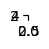

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(0,0))
plt.plot([1,2,3,4])
plt.show()

c:\Users\u1819911\Anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


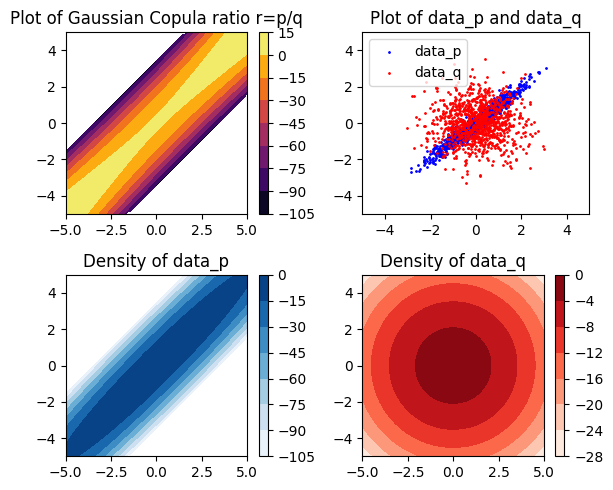

In [2]:

import torch
import numpy as np


# Gaussian helper functions
def pdf_std_normal(input):
  return torch.distributions.normal.Normal(loc = 0, scale = 1).log_prob(input).exp()

def inverse_std_normal(input):
  return torch.distributions.normal.Normal(loc = 0, scale = 1).icdf(input)

def bvn_density(rho, x, y, shift = 0.0, scale = 1.0):

   mean = torch.tensor([shift, shift])
   covariance_matrix = torch.tensor([[scale, rho], [rho, scale]])
   multivariate_normal = torch.distributions.MultivariateNormal(mean, covariance_matrix)

   l = len(x)
   input = torch.cat([x.reshape(l, 1), y.reshape(l, 1)], dim=1)

   return multivariate_normal.log_prob(input).exp()

def GC_density(rho, x, y):
  '''
  Gaussian Copula pdf on data scale
  '''
  f_1 = pdf_std_normal(x).log()
  f_2 = pdf_std_normal(y).log()
  low = f_1 + f_2

  up = bvn_density(rho = rho, x = x, y = y).log()

  return (up - low).exp()

N = 1000
data_p = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0.97], [0.97, 1.0]])).sample((N,))
data_q = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0], [0, 1.0]])).sample((N,))

## Plots of Gaussian Copula (the ratio r), and samples from p and q
xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5., 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

px = GC_density(rho = 0.97, x = uvinput[:,0], y = uvinput[:,1])

fig, axs = plt.subplots(2, 2, figsize=(6, 5))  

# Plot of Gaussian Copula ratio r=p/q
contour_plot = axs[0, 0].contourf(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100).log(), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0, 0]) 
axs[0, 0].set_title('Plot of Gaussian Copula ratio r=p/q')

# Plot of data_p and data_q
axs[0, 1].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0, 1].scatter(data_q[:, 0], data_q[:, 1], s=1, color='red', label='data_q')
axs[0, 1].set_xlim([-5, 5])  
axs[0, 1].set_ylim([-5, 5])  
axs[0, 1].set_title('Plot of data_p and data_q')
axs[0, 1].legend()

# Density plot of data_p
density_p = bvn_density(rho = 0.97, x = uvinput[:,0], y = uvinput[:,1]).log()
density_p_plot = axs[1, 0].contourf(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[1, 0])
axs[1, 0].set_title('Density of data_p')

# Density plot of data_q
density_q = bvn_density(rho = 0, x = uvinput[:,0], y = uvinput[:,1]).log()
density_q_plot = axs[1, 1].contourf(xgrid.numpy(), ygrid.numpy(), density_q.reshape(100, 100), cmap='Reds')
fig.colorbar(density_q_plot, ax=axs[1, 1])
axs[1, 1].set_title('Density of data_q')

plt.tight_layout()
plt.show()

In [80]:
def log_ratio(theta, data):
  '''
  Vectorized version of a regression r = theta_0 + theta_1*x1 + theta_2*x2 + theta_3*x1^2 + theta_4*x2^2 + theta_5*x1*x2
  theta : regression coefficients (n_theta*1)
  data = [x1, x2] : list of n tuplets (n*dim)
  '''
  x1 = data[:,0]
  x2 = data[:,1]
  return theta[0] + theta[1]*x1 + theta[2]*x2 + theta[3]*(x1)**2 +theta[4]*(x2)**2 + theta[5]*x1*x2

def Logistic_loss(r_p,r_q):
    '''
    Vectorised version of the logistic loss function from TRE eq(1)
    '''
    return -(r_p /(1+r_p)).log() - (1/(1+r_q)).log() 

In [203]:
import torch.optim as optim
import scipy.stats as scs

theta = torch.tensor(torch.ones(6), requires_grad=True)
data_p = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 1000))
data_q = torch.tensor(scs.t(10).rvs(size = 2000).reshape(1000,2))
data_p.requires_grad = False
data_q.requires_grad = False

theta_history = []
loss_history = []
learning_rate = 0.5
optimizer = optim.SGD([theta], lr=learning_rate)

for t in range(2000):
    if t % 1000 == 0:
        print("Iteration: ", t)
    r_p = log_ratio(theta = theta, data = data_p).exp()
    r_q = log_ratio(theta = theta, data = data_q).exp()
    loss = Logistic_loss(r_p,r_q).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    theta_history.append(theta.clone().detach().numpy())
    loss_history.append(loss.clone().detach().item())

print(theta)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_18660\2461942588.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.ones(6), requires_grad=True)


Iteration:  0
Iteration:  1000
tensor([ 1.2313, -0.1630,  0.2688, -5.6025, -5.5565, 11.6471],
       requires_grad=True)


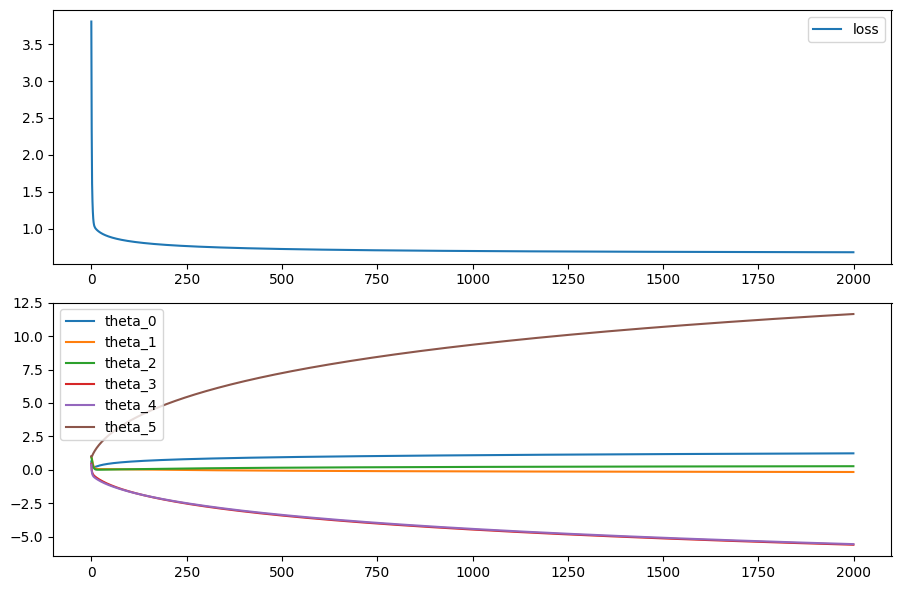

theta:  tensor([ 1.2313, -0.1630,  0.2688, -5.6025, -5.5565, 11.6471],
       requires_grad=True)


In [204]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6))

# Plot loss history in the first subplot
axs[0].plot(loss_history[-5000:], label='loss')
axs[0].legend()

# Plot theta history in the second subplot
axs[1].plot(theta_history, label='theta')
axs[1].legend(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5'])

plt.tight_layout()
plt.show()
print('theta: ', theta) # tensor([ 1.3524, -0.0822,  0.1119, -6.8440, -6.5374, 13.7761]

Text(0.5, 1.0, 'Estimated ratio $\\hat{r}=\\beta *\\phi(x_1,x_2)$')

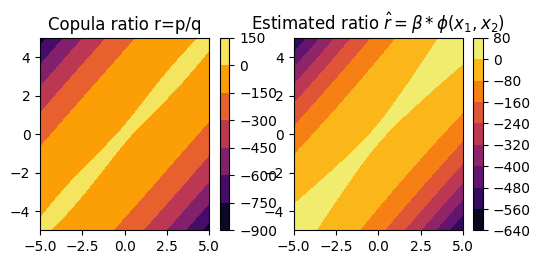

In [205]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))  

# Plot of Gaussian Copula ratio r=p/q
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])-scs.t(10).logpdf(x = uvinput[:,0])-scs.t(10).logpdf(x = uvinput[:,1])
contour_plot = axs[0].contourf(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0]) 
axs[0].set_title('Copula ratio r=p/q')

# Plot of ratio 
ratio = log_ratio(theta = theta, data = uvinput).detach().numpy()
ratio_plot = axs[1].contourf(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[1])
axs[1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

### Other simple 2D examples


c:\Users\u1819911\Anaconda3\lib\site-packages\clayton\rng\base.py:332: RuntimeWarning: divide by zero encountered in divide
  geninv = self._generator_inv(samplegamma/samplefrailty)
c:\Users\u1819911\Anaconda3\lib\site-packages\clayton\rng\base.py:332: RuntimeWarning: overflow encountered in divide
  geninv = self._generator_inv(samplegamma/samplefrailty)


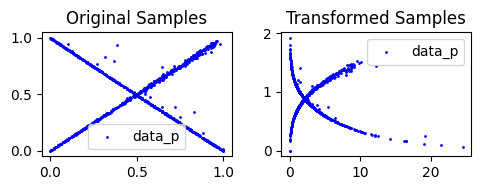

In [876]:
from clayton.rng.archimedean import Clayton
from scipy.stats import gamma, weibull_min

# [0-1] scale samples from 2 Clayton copulas
cla1 = Clayton(theta=110, n_samples=500)
samples_1 = cla1.sample_unimargin()
cla2 = Clayton(theta=-0.99, n_samples=500)
samples_2 = cla2.sample_unimargin()

samples = np.concatenate((samples_1, samples_2))

# Transform the samples
transformed_samples_1 = gamma(a=1,scale=3).ppf(samples[:,0])
transformed_samples_2 = weibull_min(c=3).ppf(samples[:,1])

# Concatenate the transformed samples

fig, axs = plt.subplots(1, 2, figsize=(5, 2))
axs[0].scatter(samples[:,0], samples[:,1], s=1, color='blue', label='data_p')
axs[0].set_title('Original Samples')
axs[0].legend()
axs[1].scatter(transformed_samples_1, transformed_samples_2, s=1, color='blue', label='data_p')
axs[1].set_title('Transformed Samples')
axs[1].legend()
plt.tight_layout()
plt.show()

#copula plot


In [367]:
import torch.optim as optim
import scipy.stats as scs

theta = torch.tensor(torch.ones(6), requires_grad=True)
data_p = torch.tensor(np.column_stack((transformed_samples_1,transformed_samples_2)))
data_q = torch.tensor(np.column_stack((np.random.permutation(transformed_samples_1),np.random.permutation(transformed_samples_2))))
data_p.requires_grad = False
data_q.requires_grad = False

theta_history = []
loss_history = []
learning_rate = 0.005
optimizer = optim.SGD([theta], lr=learning_rate)

for t in range(50000):
    if t % 1000 == 0:
        print("Iteration: ", t, "Loss: ", loss, "Theta: ", theta)
    r_p = log_ratio(theta = theta, data = data_p).exp()
    r_q = log_ratio(theta = theta, data = data_q).exp()
    loss = Logistic_loss(r_q,r_p).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    theta_history.append(theta.clone().detach().numpy())
    loss_history.append(loss.clone().detach().item())



C:\Users\u1819911\AppData\Local\Temp\ipykernel_18660\3688201860.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.ones(6), requires_grad=True)


Iteration:  0 Loss:  tensor(2.7252, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)
Iteration:  1000 Loss:  tensor(1.4426, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([ 0.1048, -0.1733,  0.0906,  0.0272,  0.0039,  0.0806],
       requires_grad=True)
Iteration:  2000 Loss:  tensor(1.4402, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([ 0.0858, -0.1555,  0.0139,  0.0182, -0.1189,  0.1677],
       requires_grad=True)
Iteration:  3000 Loss:  tensor(1.4392, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([ 0.1161, -0.1582, -0.0050,  0.0167, -0.1663,  0.1870],
       requires_grad=True)
Iteration:  4000 Loss:  tensor(1.4381, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([ 0.1498, -0.1687, -0.0121,  0.0169, -0.1931,  0.1964],
       requires_grad=True)
Iteration:  5000 Loss:  tensor(1.4370, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([ 0.1801, -0.1802, -0.017

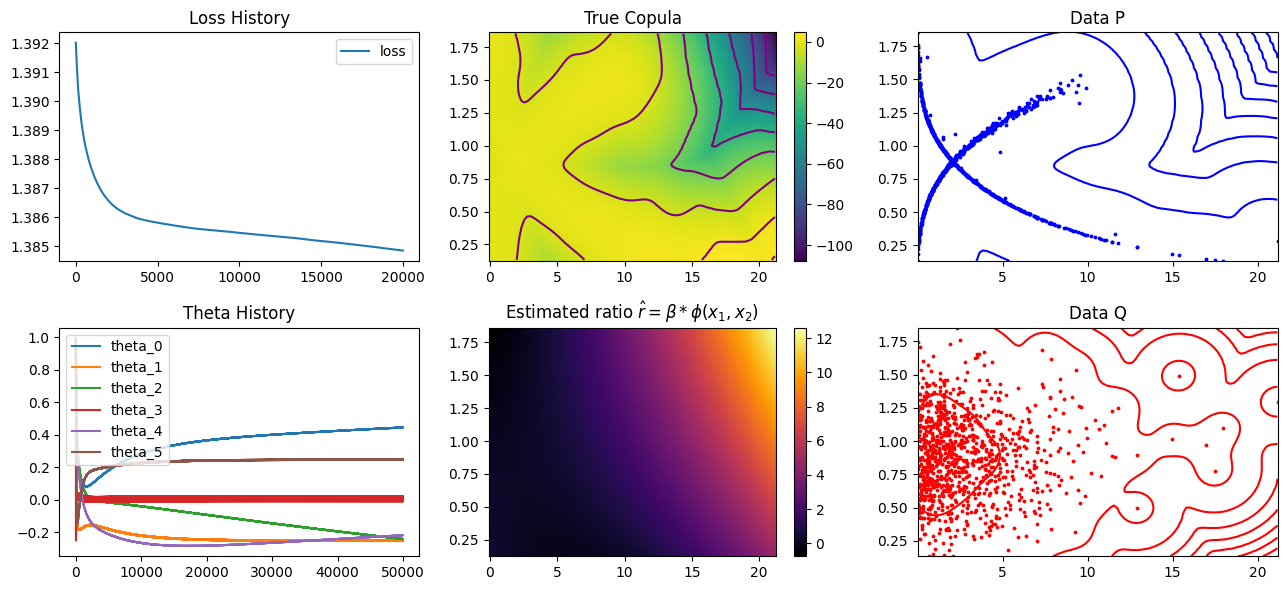

In [515]:
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

# KDEs of the transformed samples
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]))
kde_p = gaussian_kde(data_p.T)
kde_q = gaussian_kde(data_q.T)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)

fig, axs = plt.subplots(2, 3, figsize=(13, 6))

# Plot loss history in the first cell
axs[0, 0].plot(loss_history, label='loss')
axs[0, 0].legend(['loss'])
axs[0, 0].set_title('Loss History')

# Plot theta history in the second cell
axs[1, 0].plot(theta_history, label='theta')
axs[1, 0].legend(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5'])
axs[1, 0].set_title('Theta History')

# Plot true copula in the third cell
Z1 = np.log(kde(np.vstack([X.ravel(), Y.ravel()])))
Z2 = gamma(a=1,scale=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[0]) + weibull_min(c=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[1])
Z = np.reshape(Z1 - Z2, X.shape)
pcm = axs[0, 1].pcolormesh(X, Y, Z,  rasterized=True)
fig.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].contour(X, Y, Z_p/Z_q,norm=LogNorm(), colors='purple')
axs[0, 1].set_title('True Copula')

# Plot of ratio in the fourth cell
ratio = log_ratio(theta, data=torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)).detach().numpy()
cfm = axs[1, 1].pcolormesh(x_grid, y_grid, ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(cfm, ax=axs[1, 1])
axs[1, 1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

# Plot data_p and data_q in the fifth and sixth cells
axs[0, 2].scatter(data_p[:,0],data_p[:,1], s=3, color='blue', label='data_p')
axs[0, 2].contour(X, Y, Z_p,norm=LogNorm(), colors='blue')
axs[0, 2].set_title('Data P')
axs[1, 2].scatter(data_q[:,0],data_q[:,1], s=3, color='red', label='data_q')
axs[1, 2].contour(X, Y, Z_q,norm=LogNorm(), colors='red')
axs[1, 2].set_title('Data Q')

plt.tight_layout()
plt.show()



### MLP for classification

In [939]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.02):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Dropout(dropout_p), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

    def train(self, data_p, data_q, steps=2000, learning_rate=0.005, verbose=True):
        self.data_p = data_p
        self.data_q = data_q
        param_history = []
        loss_history = []
        # Define the optimizer (Stochastic Gradient Descent)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate,  weight_decay=0.01)
        #scheduler = StepLR(optimizer, step_size=5000, gamma=0.95)
        # Define your learning rate scheduler
        #lambda1 = lambda epoch: epoch // 30
        #lambda2 = lambda epoch: 0.95 ** epoch
        #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
        
        # Train the model
        loss = 1 
        for t in range(steps):
            '''if abs(loss-2*torch.tensor(0.5).log())<10e-10:
                print('OPSIE DAISY WE HAD A PROBLEM')
                for param in self.parameters():
                    noise = 10e-5*torch.randn_like(param) # generate noise with the same shape as param
                    param.data.add_(noise)  # add the noise to the parameter'''
            optimizer.zero_grad()
            r_p = self.forward(data_p.float()).exp()
            r_q = self.forward(data_q.float()).exp()
            loss = Logistic_loss(r_p,r_q).mean() 
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_value_(self.parameters(), clip_value=5.0)
            optimizer.step()

            with torch.no_grad():    
                loss_history.append(loss.clone().detach().item()) 
                if t % 1000 == 0:
                    #permute data_q
                    data_q = torch.tensor([np.random.permutation(data_q[:,0]),np.random.permutation(data_q[:,1])]).T
                    param_history.append(np.concatenate([t.view(-1).numpy() for t in self.state_dict().values()]))
                    if verbose:
                        print("Iteration: ", t, "Loss: ", loss)
                        print("MLP parameters: ", param_history[-1][:5])
                    # Manually decrease learning rate based on the last 10 entries of loss_history having increased
                    last_losses = loss_history[-20:]
                    increases = sum(x < y for x, y in zip(last_losses, last_losses[1:]))
                    if increases>10:  # Count how many times the loss has increased
                        print("Decreasing learning rate!")
                        for param_group in optimizer.param_groups:
                            param_group['lr'] *= 0.97  # Decrease learning rate by 10%
                            if param_group['lr']<10e-6:
                                print("Learning rate too low, stopping training!")
                                break
        self.param_history = param_history
        self.loss_history = loss_history

                    
    def ratio_for_plot(self):
        data_scale_p=np.linspace(self.data_p.min(),data_p.max(),100)
        data_scale_q=np.linspace(self.data_q.min(),data_q.max(),100)
        X, Y = np.meshgrid(data_scale_p, data_scale_q)
        with torch.no_grad():
            ratio = self.forward(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
        return ratio.reshape(100, 100)
    
    def diagnostics(self, loss_lim = None):
        ''' 
        Plot loss history and theta history
        loss_lim: to have [-k:] to plot the last k iterations
        '''
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        # Plot loss history in the first cell
        if loss_lim is not None:
            axs[0].plot(self.loss_history[-loss_lim:], label='loss')
        else:
            axs[0].plot(self.loss_history, label='loss')
        axs[0].legend(['loss'])
        axs[0].set_title('Loss History')
        # Plot theta history in the second cell
        axs[1].plot(self.param_history, label='theta')
        axs[1].set_title('Theta History')
        plt.tight_layout()
        plt.show()



In [940]:
mlp = MLP(2, 30, 1)
data_p_norm = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 5000))
data_q_norm = torch.tensor([np.random.permutation(data_p_norm[:,0]),np.random.permutation(data_p_norm[:,1])]).T
mlp.train(data_p_norm, data_q_norm, steps=1000000, learning_rate=0.005, verbose=True)


Iteration:  0 Loss:  tensor(1.3867, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.52022052 -0.27840197  0.09900355 -0.38535061 -0.24450919]
Iteration:  1000 Loss:  tensor(0.0616, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.0558598  -0.02454036  0.02125338 -0.04343496 -0.00549406]
Iteration:  2000 Loss:  tensor(0.0602, grad_fn=<MeanBackward0>)
MLP parameters:  [-5.64921647e-02 -4.02819924e-02  2.25208066e-02 -5.33233546e-02
  2.25360168e-22]


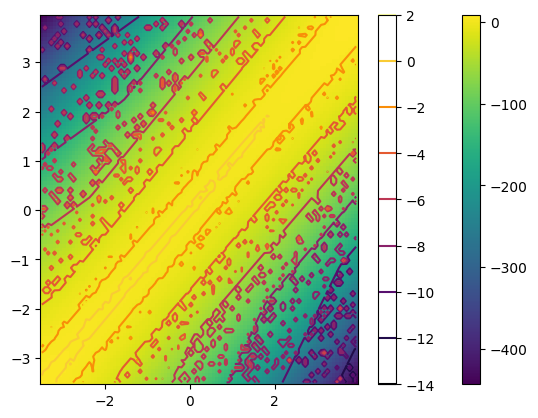

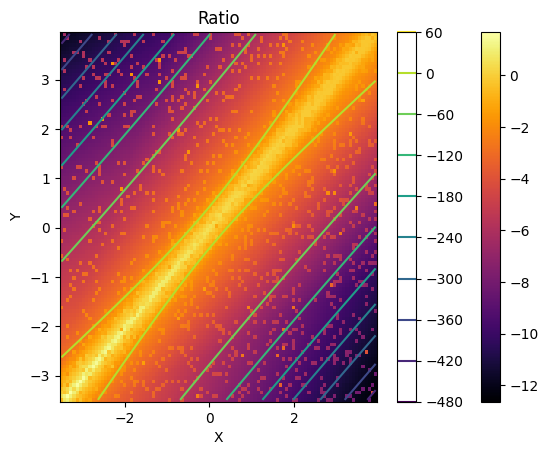

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Parameters
mu = torch.zeros(2)  # mean
cov = torch.tensor([[1,0.97],[0.97,1]])  # covariance matrix, identity matrix indicates independence

# Create grid and multivariate normal
x = torch.linspace(mlp.data_p.min(),mlp.data_p.max(),100)
y = x
X, Y = torch.meshgrid(x, y)
pos = torch.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
with torch.no_grad():
    ratio = mlp.forward(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
rv = MultivariateNormal(mu, cov)
rv_ind = MultivariateNormal(torch.zeros(2), torch.eye(2))
# Make a 2D contour plot
plt.pcolormesh(X.numpy(), Y.numpy(),(rv.log_prob(pos)).numpy()-(rv_ind.log_prob(pos)).numpy(), cmap='viridis')
plt.colorbar()
plt.contour(X.numpy(), Y.numpy(),ratio.reshape(100,100), cmap='inferno')
plt.colorbar()
plt.show()
with torch.no_grad():
    ratio = mlp.forward(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
plt.pcolormesh(X.numpy(), Y.numpy(),ratio.reshape(100,100), cmap='inferno')
plt.colorbar()

plt.contour(X.numpy(), Y.numpy(),(rv.log_prob(pos)).numpy()-(rv_ind.log_prob(pos)).numpy(), cmap='viridis')

plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title('Ratio')
plt.show()

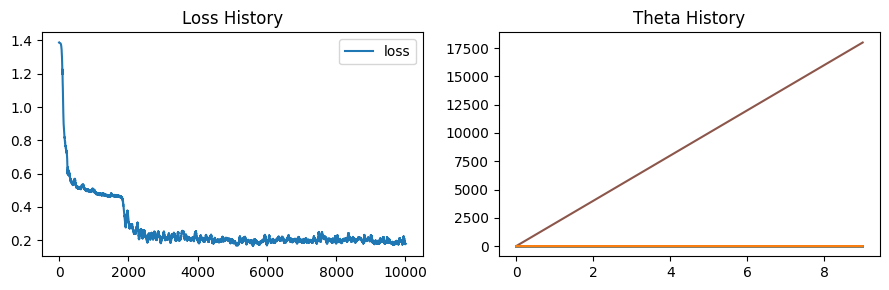

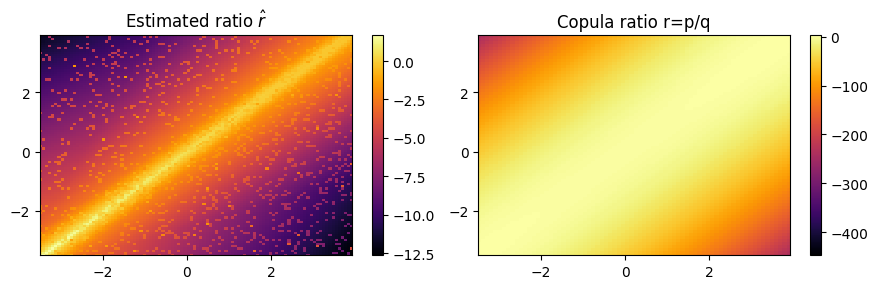

In [ ]:
mlp.diagnostics(loss_lim=10000)

data_scale=np.linspace(mlp.data_p.min(),mlp.data_p.max(),100)
x_grid, y_grid = np.meshgrid(data_scale, data_scale)
ratio = mlp.ratio_for_plot()

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
# Plot ratio
cfm = axs[0].pcolormesh(x_grid, y_grid, ratio.reshape(100, 100), cmap='inferno')
axs[0].set_xlim([mlp.data_p.min(),mlp.data_p.max()])
axs[0].set_ylim([mlp.data_p.min(),mlp.data_p.max()])
fig.colorbar(cfm, ax=axs[0])
axs[0].set_title(r'Estimated ratio $\hat{r}$')

# Plot copula
uvinput = torch.cat([torch.tensor(x_grid).reshape(-1, 1), torch.tensor(y_grid).reshape(-1, 1)], dim=1)
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])-scs.t(10).logpdf(x = uvinput[:,0])-scs.t(10).logpdf(x = uvinput[:,1])
contour_plot = axs[1].pcolormesh(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
axs[1].set_title('Copula ratio r=p/q')
axs[1].set_xlim([mlp.data_p.min(),mlp.data_p.max()])
axs[1].set_ylim([mlp.data_p.min(),mlp.data_p.max()])
fig.colorbar(contour_plot, ax=axs[1]) 

plt.tight_layout()
plt.show()

In [ ]:
mlp2 = MLP(2, 30, 1)
data_p = torch.tensor(np.column_stack((transformed_samples_1,transformed_samples_2)))
data_q = torch.tensor(np.column_stack((np.random.permutation(transformed_samples_1),np.random.permutation(transformed_samples_2))))
data_p.requires_grad = False
data_q.requires_grad = False
mlp2.train(data_p, data_q, steps=1000000, learning_rate=0.005, verbose=True)

Iteration:  0 Loss:  tensor(1.3973, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.14595582  0.13338725 -0.63107669 -0.49666613  0.42504913]
Iteration:  1000 Loss:  tensor(1.0125, grad_fn=<MeanBackward0>)
MLP parameters:  [-3.39991041e-03 -1.68484643e-01 -3.65217477e-02 -2.34424882e-02
  2.18327987e-05]
Decreasing learning rate!
Iteration:  2000 Loss:  tensor(0.9578, grad_fn=<MeanBackward0>)
MLP parameters:  [-1.33574544e-03 -8.55945274e-02 -2.68078465e-02 -1.50846811e-02
  5.86758979e-17]
Iteration:  3000 Loss:  tensor(0.9205, grad_fn=<MeanBackward0>)
MLP parameters:  [ 1.28157763e-03 -2.46341024e-02 -3.02854814e-02 -5.55490470e-03
 -7.14330109e-40]
Iteration:  4000 Loss:  tensor(0.9474, grad_fn=<MeanBackward0>)
MLP parameters:  [ 1.39522948e-04 -4.79377093e-07 -2.31143273e-02 -1.53191611e-02
  1.85391787e-42]
Iteration:  5000 Loss:  tensor(0.9777, grad_fn=<MeanBackward0>)
MLP parameters:  [ 3.05885951e-05  1.08664438e-23 -3.81572284e-02 -1.08293593e-02
  1.85391787e-42]
Iteration:  60

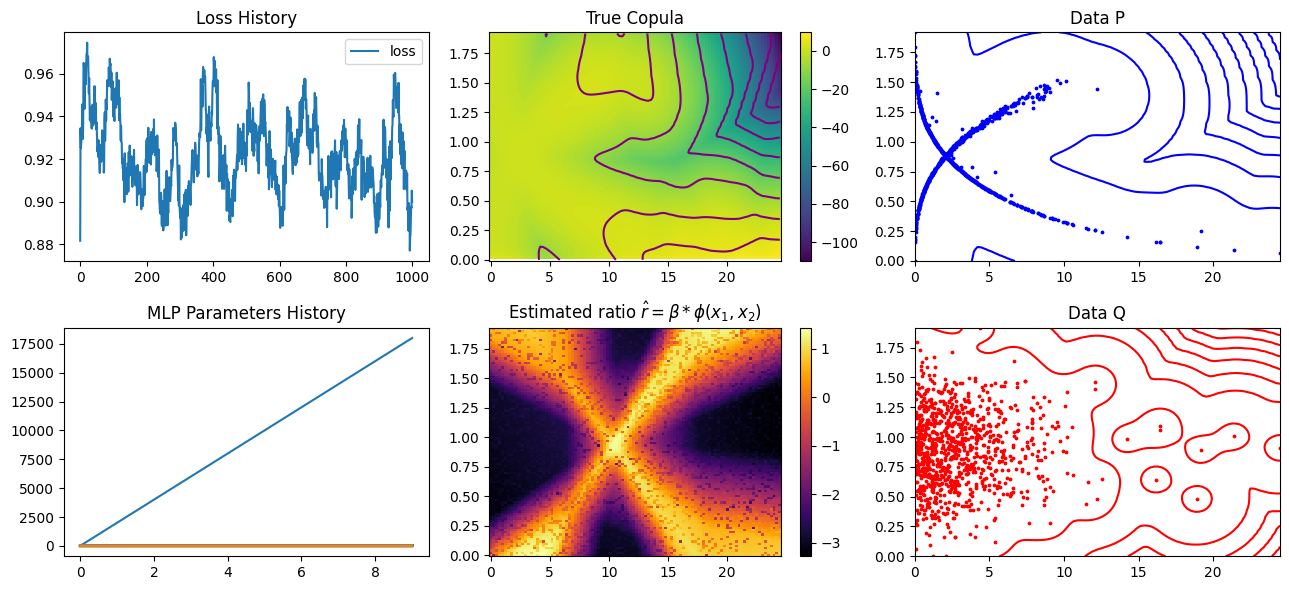

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(2, 3, figsize=(13, 6))

# Plot loss history in the first cell
#axs[0, 0].plot(loss_history_mlp[-500:], label='loss')
axs[0, 0].plot(mlp2.loss_history[-1000:], label='loss')
axs[0, 0].legend(['loss'])
axs[0, 0].set_title('Loss History')

# Plot MLP parameters history in the second cell
params_history_mlp_transposed = np.array(mlp2.param_history).T # Transpose the array so that each row corresponds to a different parameter
for i, param_history in enumerate(params_history_mlp_transposed):
    axs[1, 0].plot(param_history, label=f'param_{i}')
axs[1, 0].set_title('MLP Parameters History')

# Plot true copula in the third cell
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]))
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z1 = np.log(kde(np.vstack([X.ravel(), Y.ravel()])))
Z2 = gamma(a=1,scale=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[0]) + weibull_min(c=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[1])
Z = np.reshape(Z1 - Z2, X.shape)
pcm = axs[0, 1].pcolormesh(X, Y, Z,  rasterized=True)
fig.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].contour(X, Y, Z_p/Z_q,norm=LogNorm(), colors='purple')
axs[0, 1].set_title('True Copula')

# Plot of ratio in the fourth cell
with torch.no_grad():
    ratio = mlp2.forward(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
#ratio = log_ratio(theta, data=torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)).detach().numpy()
cfm = axs[1, 1].pcolormesh(X, Y,ratio.reshape(100,100), cmap='inferno')
fig.colorbar(cfm, ax=axs[1, 1])
axs[1, 1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')


# Plot data_p and data_q in the fifth and sixth cells
kde_p = gaussian_kde(data_p.T)
kde_q = gaussian_kde(data_q.T)
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)
axs[0, 2].scatter(data_p[:,0],data_p[:,1], s=3, color='blue', label='data_p')
axs[0, 2].contour(X, Y, Z_p,norm=LogNorm(), colors='blue')
axs[0, 2].set_title('Data P')
axs[1, 2].scatter(data_q[:,0],data_q[:,1], s=3, color='red', label='data_q')
axs[1, 2].contour(X, Y, Z_q,norm=LogNorm(), colors='red')
axs[1, 2].set_title('Data Q')

plt.tight_layout()
plt.show()

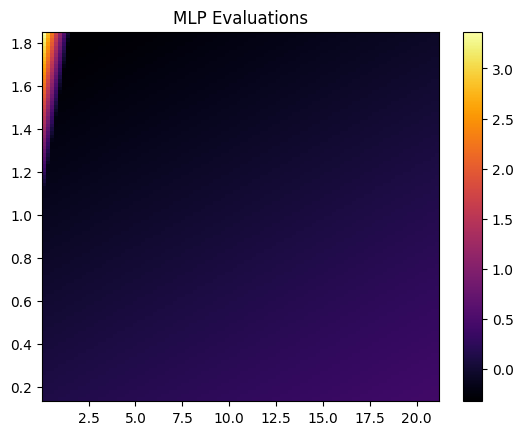

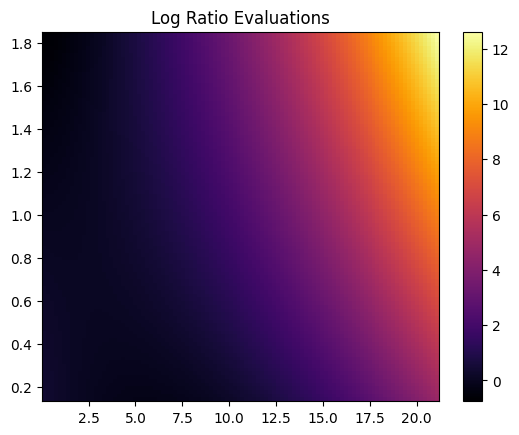

In [ ]:
# Create a grid of (x, y) pairs
xv, yv = np.meshgrid(x_grid, y_grid)

# Reshape the grid arrays and stack them into a 2D array
grid = torch.tensor(np.stack((xv.ravel(), yv.ravel()), axis=-1)).float()

# Apply the mlp and log_ratio functions to each pair
mlp_evaluations = mlp2(grid).detach().numpy().reshape(100,100)
log_ratio_evaluations = log_ratio(theta = theta, data = grid).detach().numpy().reshape(100,100)

# Plot mlp_evaluations
plt.imshow(mlp_evaluations, cmap='inferno', extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()], origin='lower', aspect='auto')
plt.colorbar()
plt.title("MLP Evaluations")
plt.show()

# Plot log_ratio_evaluations
plt.imshow(log_ratio_evaluations, cmap='inferno', extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()], origin='lower', aspect='auto')
plt.colorbar()
plt.title("Log Ratio Evaluations")
plt.show()